# Digital signal processing - 8

| ** Title ** | Digital signal processing |
| --- | --- |
| ** Author ** | Alexander Kapitanov |
| ** Contact ** | sallador@bk.ru |
| ** Project lang ** | Python |
| ** Packages ** | numpy, scipy, matplotlib |
| ** License ** | GNU GPL 3.0 |


## Introduction

Here is a tutorial on the basics of ** digital signal processing ** using the Python programming language. It is assumed that the reader has basic knowledge of higher mathematics, as well as knows the Python language and at least superficially knows various python libraries - numpy / scipy, matplotlib and others.

For MATLAB / GNU Octave users, mastering the material from the point of view of the program code will not be difficult, since the main functions and their attributes are largely identical and similar to methods from python libraries.

## Multirate Signal Processing

In the previous sections, we examined digital filters - finite impulse response (FIR) and infinite impulse response (IIR). Multirate processing assumes that in the process of linear conversion of digital signals, it is possible to change the sampling frequency in the direction of decreasing or increasing, or in a fractional number of times. This leads to more efficient signal processing, since it opens up the possibility of using the minimum allowable sampling rates and, as a result, a significant decrease in the required computing performance of the designed digital system. To convert the sampling rate to ** fractional ** times, it is necessary to use the up-sampling and down-sampling stages together.

The main building blocks of a multi-rate DSP system are sample rate compressors and expanders, which down and up the sampling rate of the converted digital sequences. At the same time, if lowering the sampling frequency by R times (R is an integer) with the help of a compressor reduces to the fact that only samples with numbers divisible by R are stored in the output signal, then increasing the sampling frequency by R times using an expander assumes placement (R -1) zeros between each pair of adjacent samples of the input signal.

** Decimation ** (decimation) - downsampling. Downsampling is obtained by storing one sample of the input sequence and removing R-1 samples of the signal sequence, which is expressed by the following formula:

$ y [n] = x [nR] $

Simple compression of digital sequences leads to the superposition of the periodic components of the spectrum of the "decimated" signal due to the reflection effect (the spectral characteristics of the output signal deteriorate). Therefore, downsampling requires a low pass filter (LPF). Thus, the block diagram of the decimator filter is obtained by cascading the LPF and the compressor. Then, the formula connecting the input and output signals is converted to the form:

$ y [n] = \sum_ {k = 0} ^ {N-1} x [nR-k] \cdot h [k] $,

Where
- $ h [k] $ - samples of the filter with a finite impulse response,
- $ x [nR-k] $ - decimated input signal,

The decimator filter output only stores every Rth sample. Therefore, for a class of filters with finite impulse response (FIR filters), when the summation limits take finite values, it is potentially possible to reduce the reduced computational costs by a factor of R. This is expressed in a decrease in the processing speed or in a decrease in the amount of spent logical resources, if we consider FPGA microcircuits.

** Interpolation ** - upsampling. The operation of increasing the sampling rate is specified by introducing R-1 zero samples into the input sequence and expressed by the formula:
 
$
y[n] = 
 \begin{cases}
   x[n/R] , n = 0, L, 2L, ...\\
   0 , n \ne 0, L, 2L, ...
 \end{cases}
$

Since placing zeros is equivalent to compressing by R times and periodically continuing the spectrum of the input signal, when the sampling rate is increased, a low-pass filter is also required. Thus, the block diagram of the interpolator filter is obtained by cascading the expander and the low-pass filter, and the formula for the output signal is converted to the form:

$ y [n] = \sum_ {k = 0} ^ {N-1} x [nR-k] \cdot h [k] $,

Where
- $ h [k] $ - samples of the filter with a finite impulse response,
- $ x [nR-k] $ - input signal with insertion of zeros between samples.

The output signal of the interpolator filter uses the R times "decimated" input sequence. Consequently, the computational costs and memory of the FIR filter are potentially reduced by a factor of R.


### CIC filters

In the previous section, a class of ** homogeneous FIR filters ** was considered. With their help it is possible to design filters to change the sampling rate. These filters do not require a multiplication operation to implement, hence the filter is fast enough and is fairly well implemented on devices such as FPGAs.

The disadvantage of such filters is the high level of side lobes. The side lobes of the frequency response are suppressed by cascading the filters, while the position of the zeros does not change, but only the ratio of the levels of the main and side lobes changes, the relative level of the side lobes decreases when the frequency response is multiplied.

The second disadvantage of homogeneous filters is ** non-rectangular ** frequency response shape. To make it more rectangular, an FIR equalization filter is used, so the shape of the main lobe becomes more rectangular, but the level of the side lobes increases.

Homogeneous filters, forming a cascade of an integrator and a differentiator, are called ** Cascaded integrator-comb (CIC) filters **. Further in the text we will use this terminology.

The CIC filter consists of two basic units: an integrator and a comb filter (differentiator). The integrator (int) is a conventional first order IIR filter designed as the simplest accumulator. A comb filter (comb) is a first order FIR filter. The following figure shows the circuits of the integrator and the differentiator:

<img src="https://raw.githubusercontent.com/capitanov/dsp-theory/master/img/cic_comb_int.svg?sanitize=true" alt="Comb & Integrator" style="width: 70%;"/>

Between the integrator and the comb filter, there is often an integer up-sampling or down-sampling node - $ R $.
- In case of downsampling, each R-sample is selected from the input sequence, forming a decimated output sequence.
- In the case of upsampling, zeros are simply inserted between samples of the input sequence, which are then smoothed in the integrating section, forming a sequence at the increased sampling rate.

Formulas for the transfer and amplitude-frequency characteristics of the filter:

#### Transfer characteristic

$ H (z) = (\sum_ {k = 0} ^ {RM-1} z ^ {- k}) ^ N = [\frac {1-z ^ {- RM}} {1-z ^ {- 1}}] ^ {N} $

#### Frequency response formula

$ \| H (f) \| = [\frac {sin (\pi RMf)} {sin (\pi f)}] ^ {N} $

### CIC filter decimator

When a CIC filter is used to lower the sampling rate, it is called a decimator. In this case, the integrator is the first link, then the sampling rate is lowered and, finally, there is a differentiating filter link.

<img src = "https://raw.githubusercontent.com/capitanov/dsp-theory/master/img/cic_decimator.svg?sanitize=true" alt = "CIC Decimator" style = "width: 70%;" />

### CIC filter interpolator

When a CIC filter is used for upsampling, it is called an interpolator. In this case, the differentiating link comes first, then the sampling rate is increased and, finally, the integrating filter link comes.

<img src = "https://raw.githubusercontent.com/capitanov/dsp-theory/master/img/cic_interp.svg?sanitize=true" alt = "CIC Interpolator" style = "width: 70%;" />

The cascading combination of an integrator and a comb filter without decimation and interpolation is called a ** moving average filter **. The level of the first side lobe of such a filter is only ** - 13 dB **, which is low enough for serious DSP tasks. In most practical tasks, the parameter $ M = 1 $. Below in the text the implementation of filters with this parameter value will be presented.

Due to the linearity of the mathematical operations occurring in the CIC filter, it is possible to cascade several filters in a row. This results in a proportional decrease in the side lobe level, but also increases the "roll-off" of the main lobe of the frequency response. Thus, when the N-stage connection of the same type of CIC filters is a multiplication of identical transfer characteristics. Typically, integrator and comb sections are grouped together by type. For example, first $ N $ sections of the same type of integrators are sequentially put, then N sections of the same type of differentiating filters. The following figure shows a CIC third-order decimator filter $ N = 3 $.

<img src = "https://raw.githubusercontent.com/capitanov/dsp-theory/master/img/cic_decim_order.svg?sanitize=true" alt = "CIC N-order" style = "width: 90%;" />

The following figure shows the frequency response of the first order filter $ N = 1 $ for various parameters of the decimation coefficient $ R $:

In [1]:
import numpy as np               # Import numpy 
import matplotlib.pyplot as plt  # Import matplotlib
from scipy.signal import freqz
from scipy.fftpack import fft
%matplotlib inline

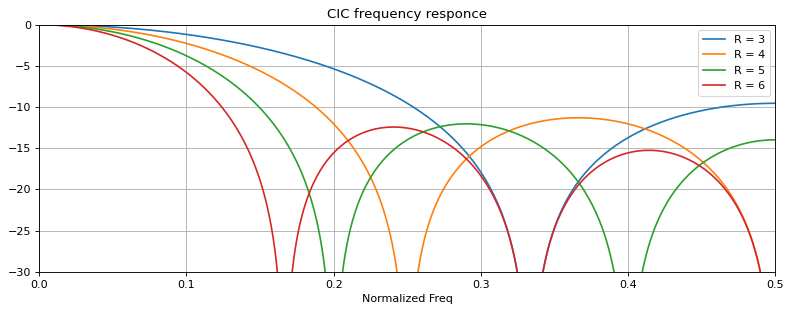

In [2]:
N = 2**15
f = np.linspace(0, 0.5, N, endpoint=True)

# Create CIC filter as recursive FIR
b = [1, 1, 1]

# Plot results
plt.figure(figsize=(10, 4), dpi=80)
for i in range(4):
    _, h = freqz(b, 1, worN=N)
    h = np.abs(h)
    plt.plot(f, 20*np.log10(h/np.max(h)+10e-12), label=f'R = {len(b)}')
    plt.xlim([0, 0.5])
    plt.ylim([-30, 0])
    plt.grid(True)
    b.append(1)
plt.legend(loc='upper right')
plt.xlabel('Normalized Freq')
plt.title('CIC frequency responce')
plt.tight_layout()

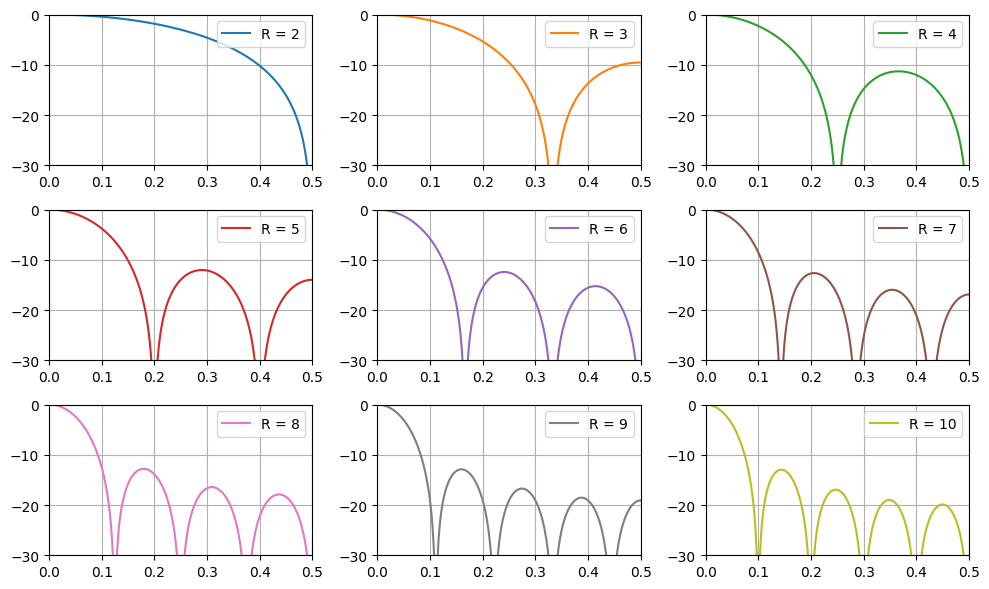

In [3]:
b = [1, 1]

# Plot results
plt.figure(figsize=(10, 6), dpi=100)
for i in range(9):
    _, h = freqz(b, 1, worN=N)
    h = np.abs(h)
    plt.subplot(3, 3, i+1)
    plt.plot(f, 20*np.log10(h/np.max(h)+10e-12), label=f'R = {len(b)}', color='C'+str(i))
    plt.xlim([0, 0.5])
    plt.ylim([-30, 0])
    plt.grid(True)
    b.append(1)
    plt.legend(loc='upper right')
plt.tight_layout()

The frequency response of the CIC filter is fully equivalent to the frequency response of the FIR filter with rectangular impulse response (IR). As you can see from the previous example, the coefficients of the numerator are an array of ones, and the coefficient of the denominator is also one.

The total IR of the filter is defined as the convolution of all the impulse responses of the stages of the integrator and comb filter. As the order of the CIC filter increases, its IC is integrated the corresponding number of times. Thus, for a first-order CIC filter, IX is a rectangle, for a second-order filter, IX is an isosceles triangle, for a third order, IX is a parabola, etc.

### Python CIC filter implementation

Unfortunately, a number of digital signal processing operations are currently missing in the Python numpy / scipy math packages. In particular, there is no implementation of CIC filters that perform the tasks of decimation and interpolation. In this regard, the `CicFilter` class has been developed, which takes an input sequence and contains two methods:
- `decimator(r, n)` - filter decimator,
- `interpolator(r, n)` - filter interpolator.

where `r` - decimation or interpolation coefficient, `n` - filter order, (parameter `m = 1` always).

In [4]:
class CicFilter:
    """
    Cascaded Integrator-Comb (CIC) filter is an optimized class of
    finite impulse response (FIR) filter.
    CIC filter combines an interpolator or decimator, so it has some
    parameters:

    R - decimation or interpolation ratio,
    N - number of stages in filter (or filter order)
    M - number of samples per stage (1 or 2)*

    * for this realisation of CIC filter just leave M = 1.

    CIC filter is used in multi-rate processing. In hardware
    applications CIC filter doesn't need multipliers, just only
    adders / subtractors and delay lines.

    Equation for 1st order CIC filter:
    y[n] = x[n] - x[n-RM] + y[n-1].


    Parameters
    ----------
    x : np.array
        input signal
    """

    def __init__(self, x):
        self.x = x

    def decimator(self, r, n):
        """
        CIC decimator: Integrator + Decimator + Comb

        Parameters
        ----------
        r : int
            decimation rate
        n : int
            filter order
        """

        # integrator
        y = self.x[:]
        for i in range(n):
            y = np.cumsum(y)

        # decimator

        y = y[::r]
        # comb stage
        return np.diff(y, n=n, prepend=np.zeros(n))

    def interpolator(self, r, n, mode=False):
        """
        CIC inteprolator: Comb + Decimator + Integrator

        Parameters
        ----------
        r : int
            interpolation rate
        n : int
            filter order
        mode : bool
            False - zero padding, True - value padding.
        """

        # comb stage
        y = np.diff(self.x, n=n,
                    prepend=np.zeros(n), append=np.zeros(n))

        # interpolation
        if mode:
            y = np.repeat(y, r)
        else:
            y = np.array([i if j == 0 else 0 for i in y for j in range(r)])

        # integrator
        for i in range(n):
            y = np.cumsum(y)

        if mode:
            return y[1:1 - n * r]
        else:
            return y[r - 1:-n * r + r - 1]

Let's test the developed class `CicFilter`. For this, we will create a helper function for plotting graphs.

In [5]:
def plot_filter(r=None, n=None, samples=100, mode=None):
    # Create signal
    tt = np.linspace(0, 1, samples)
    
    np.random.seed(1)
    if mode == 'Decimator':
        x = 1.5 * np.sin(4 * np.pi * tt) + 1.7 * np.sin(8.3 * np.pi * tt)
        x += 0.9*np.random.randn(samples)
    if mode == 'Interpolator':
        x = np.sin(1.7 * np.pi * tt) + 1.7 * np.sin(5.3 * np.pi * tt)
        x += 0.3*np.random.randn(samples)
    
    # Apply filter
    clf = CicFilter(x)
    
    if mode == 'Decimator':
        zz = [clf.decimator(i, j) for i, j in zip(r, n)]
    if mode == 'Interpolator':
        zz = [clf.interpolator(i, j, mode=True) for i, j in zip(r, n)]

    # Plot figure
    plt.figure(figsize=(12, 8), dpi=80)
    # plt.title(mode)
    plt.subplot(4, 2, 1)
    plt.title('Change N:')
    plt.plot(x, '-', color='C0', label='Signal')
    plt.xlim([0, samples-1])
    plt.legend(loc='upper right')
    plt.grid(True)

    for j in range(len(r)):
        plt.subplot(4, 2, 2+j)
        if j == 0:
            plt.title('Change R:')
        plt.stem(zz[j],
                 use_line_collection=True,
                 linefmt='C2',
                 basefmt='C0',
                 label=f'R = {r[j]}, N = {n[j]}'
                 )
        plt.grid(True)
        plt.legend(loc='upper right')
    plt.tight_layout(True)


### Python CIC filter decimator

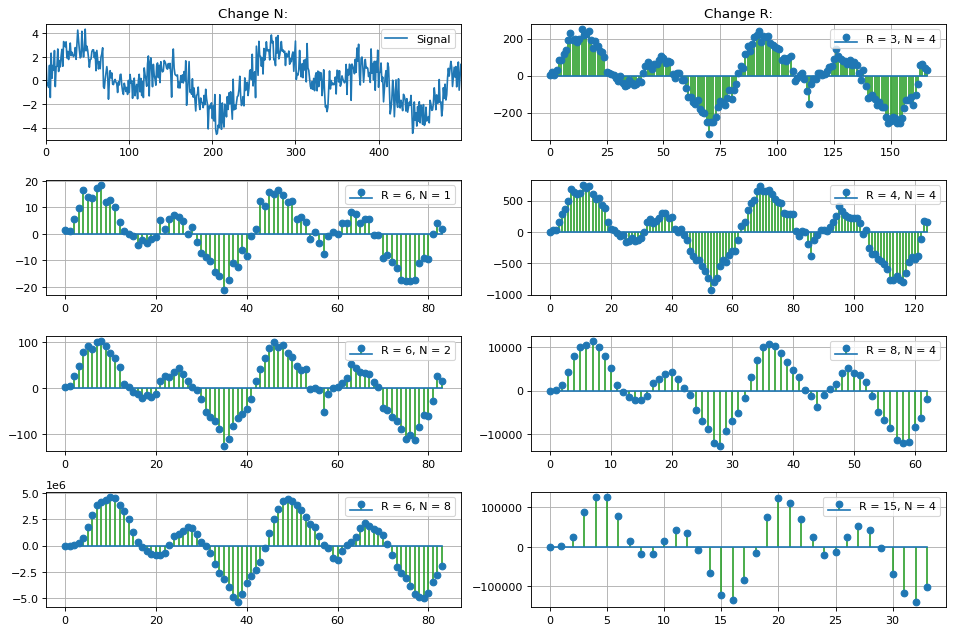

In [6]:
# Number os samples
N = 500

# Filter parameters (length of lists should be same):
flt_r = [3, 6, 4, 6, 8, 6, 15]
flt_n = [4, 1, 4, 2, 4, 8, 4]

plot_filter(r=flt_r, n=flt_n, samples=N, mode='Decimator')

### Python CIC filter interpolator

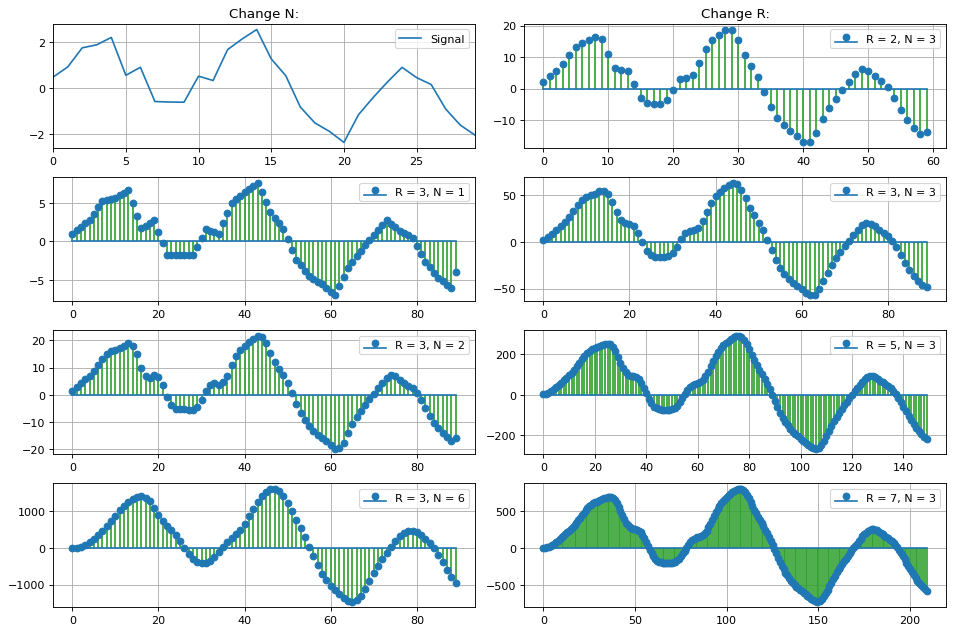

In [7]:
# Number os samples
N = 30

# Filter parameters (length of lists should be same):
flt_r = [2, 3, 3, 3, 5, 3, 7]
flt_n = [3, 1, 3, 2, 3, 6, 3]

plot_filter(r=flt_r, n=flt_n, samples=N, mode='Interpolator')

### Increase in bit depth

Unfortunately, increasing the delay $ M $ in the comb and increasing the filter order $ N $ will increase the gain. This, in turn, leads to an increase in the bit depth at the filter output. In DSP tasks where CIC filters with integer arithmetic are used, you should always remember this and make sure that the transmitted signals do not go beyond the used bit grid. For example, the negative effect of increasing the bit depth is manifested in a significant increase in the used FPGA resources. It should also be noted that the adder in the integrator circuit must be free of overflow.

Interpolator: using limited precision does not affect the internal bit width of the registers, only the last output stage is scaled. A significant increase in the bitness of data occurs in the sections of integrators.

$ B_ {OUT} = ceil [Nlog_ {2} (RM) + B_ {IN}] $

Decimator: The CIC filter decimator is very sensitive to the parameters $ M $, $ R $ and $ N $, on which the bit width of the intermediate and output data depends. Both the differentiator and the integrator affect the final bit width of the output signal.

$ B_ {OUT} = ceil [log_ {2} (\frac {(RM) ^ {N}} {R}) + B_ {IN}] $

In these formulas:
- $ B_ {IN} $ - input data width,
- $ B_ {OUT} $ - output data width,
- $ R $ - sampling rate,
- $ M $ - delay parameter,
- $ N $ - filter order (number of stages).
- `ceil` - mathematical operation of rounding up.

### Python Resampling

** Software implementation of decimation and interpolation methods **.

Decimators and interpolators are applied using some functions from the `scipy.signal` package. Let's list the main functions:

| ** Function ** | ** Description ** |
| --- | --- |
| `decimate(x, q [, n, ftype, axis, zero_phase])` | Decimation of a Signal Using a Low-Pass Filter |
| `resample(x, num [, t, axis, window])` | Changing the number of samples of the signal `x` by` q` (by the Fourier method) |
| `upfirdn(h, x [, up, down, axis])` | Three-step processing: Interpolation, filtering (FIR), decimation |
| `resample_poly(x, up, down [, axis, window])` | Changing the Number of Signal Samples Using a Polyphase Filter |

#### Decimation

The `decimate` method allows you to decimate the signal using a low-pass smoothing filter:

 - `x` - input signal (one-dimensional or multidimensional data vector
 - `q` - integer decimation coefficient
 - `n` - integer filter order, default is 8 for IIR filters and 20 for FIR filters
 - `ftype` - filter selection: IIR - `iir` or FIR - `fir`
 - `axis` - the axis along which decimation is performed (for multidimensional arrays)
 - `zero_phase` - zero phase shift. Prevents phase shift as the signal passes through the filter. The default is `True`
 
For the decimation coefficient `q > 13`, it is necessary to use a cascade connection of decimators (multiple calls of the` decimate() `method.

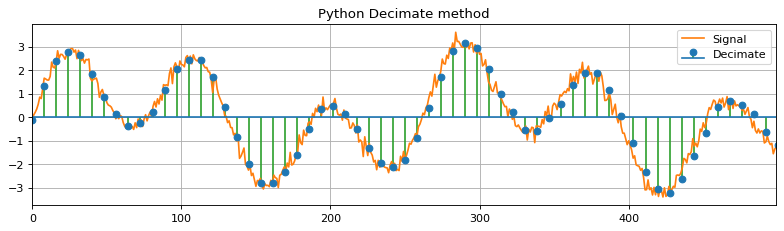

In [8]:
from scipy.signal import decimate

# Input signal
N = 500
tt = np.linspace(0, 1, N)
x = 1.5 * np.sin(4 * np.pi * tt) + 1.9 * np.sin(11.3 * np.pi * tt) + 0.2 * np.random.randn(N)

# Decimation
y = decimate(x, q=8, n=8)
ty = np.linspace(0, 1, y.size)

# Plot figure
plt.figure(figsize=(12, 3), dpi=80)
plt.title('Python Decimate method')
plt.plot(x, '-', color='C1', label='Signal')
plt.stem(np.linspace(0, N, y.size), y, use_line_collection=True, linefmt='C2', basefmt='C0', label='Decimate')
plt.xlim([0, N-1])
plt.legend(loc='upper right')
plt.grid(True)

#### Resampling

The `resample` method allows you to change the sample rate by a fractional number of times

  - `x` - input signal (one-dimensional or multi-dimensional data vector)
  - `num` - number of samples in the output signal
  - `t` - an array of timestamps for the output signal
  - `axis` - the axis along which decimation is performed (for multidimensional arrays)
  - `window` - window function used in the Fourier method when calculating the output array
 
### Decimation and interpolation with resample

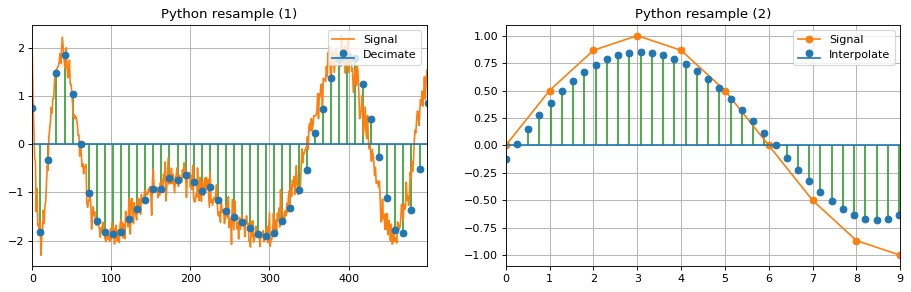

In [9]:
from scipy.signal import resample

# Input signal
N = 500
tt = np.linspace(0, 1, N)
np.random.seed(1)
x = 1.9 * np.sin(10.3 * np.pi * tt ** tt) + 0.2 * np.random.randn(N)

y = resample(x, num=50, window='blackmanharris')
ty = np.linspace(0, 1, y.size)

# Plot figure
plt.figure(figsize=(14, 4), dpi=80)
plt.subplot(1, 2, 1)
plt.title('Python resample (1)')
plt.plot(x, '-', color='C1', label='Signal')
plt.stem(np.linspace(0, N, y.size), y, use_line_collection=True, linefmt='C2', basefmt='C0', label='Decimate')
plt.xlim([0, N-1])
plt.legend(loc='upper right')
plt.grid(True)

# Input signal
N = 10
tt = np.linspace(0, 1, N)
x = np.sin(1.5 * np.pi * tt)

y = resample(x, num=40, window='blackmanharris')
ty = np.linspace(0, 1, y.size)

# Plot figure
plt.subplot(1, 2, 2)
plt.title('Python resample (2)')
plt.plot(x, '-o', color='C1', label='Signal')
plt.stem(np.linspace(0, N, y.size), y, use_line_collection=True, linefmt='C2', basefmt='C0', label='Interpolate')
plt.xlim([0, N-1])
plt.legend(loc='upper right')
plt.grid(True)

The `upfirdn` method performs processing in three stages: interpolation, filtering (FIR), signal decimation.

- `h` - FIR filter coefficients
- `x` - input signal (one-dimensional or multi-dimensional data vector)
- `up` - interpolation coefficient
- `down` - decimation factor
- `axis` - the axis along which decimation is performed (for multidimensional arrays)

The `resample_poly` method changes the number of samples of the input signal using a polyphase filter
- `x` - input signal (one-dimensional or multi-dimensional data vector)
- `up` - interpolation coefficient
- `down` - decimation factor
- `axis` - the axis along which decimation is performed (for multidimensional arrays)
- `window` - window function

### Moving Average Filter

A moving average filter (MAF *) is a type of FIR filters (in some cases IIR filters). A distinctive feature of the moving average filter is that the sum of the coefficients is equal to unity.

$ \sum_ {k = 0} ^ {N-1} b_ {k} = 1 $

As discussed in previous sections, FIR filters can be rendered recursive. Consider the following example. Let's write down the transfer characteristic of the filter:

$ H (z) = 1 + z ^ {- 1} + z ^ {- 2} + z ^ {- 3} $,

We multiply the transfer function by

$ \frac {1 - z ^ {- 1}} {(1 - z ^ {- 1}} $.

Let's skip the mathematical calculations (if desired, this can be done independently due to the triviality of the problem under consideration) and write the result:

$ H (z) = \frac {1 + z ^ {-3}} {1 - z ^ {-1}} $

The block diagram of such a filter is shown in the following figure. It consists of two circuits: a link without feedback is a differentiating one, and a link with a feedback is an integrating one (an adder with a feedback).

<img src = "https://raw.githubusercontent.com/capitanov/dsp-theory/master/img/fir_recursive.svg?sanitize=true" alt = "FIR Recursive" style = "width: 70%;" />

### Python implementation

Thus, a moving average filter can be implemented using a direct FIR filter, or using a recursive form. Parameter $ M $ - the amount of delay in the differentiating link. In addition, a moving average filter can be implemented using the ** convolution of signals ** operation (which is essentially equivalent to the implementation with a direct FIR filter). The ** kernel of the convolution ** is an array of ones.
Below are some Python Moving Average Filter implementations.

In [10]:
class MafFilter:
    """
    Moving average filter:
    
    M - moving-average step (delay in comb stage)

    Parameters
    ----------
    x : np.array
        input 1-D signal
    """

    def __init__(self, x):
        self.x = x

    def maf_conv(self, m=2):
        """
        Calculate moving average filter via convolution

        Parameters
        ----------
        m : int
            moving average step
        """
        coe = np.ones(m) / m
        return np.convolve(self.x, coe, mode='same')       
        
    def maf_fir(self, m=2):
        """
        Calculate moving average filter as FIR

        Parameters
        ----------
        m : int
            moving average step
        """
        return lfilter(np.ones(M-1), 1, self.x)     

    def maf_iir(self, m=2):
        """
        Calculate moving average filter as FIR

        Parameters
        ----------
        m : int
            moving average step
        """
        # Change to recursive form
        a = [1, -1]
        b = np.zeros(M)
        b[0], b[-1] = a
        return lfilter(b, a, self.x)

### Filtering example

In the following example, you can see the "smoothing" effect of the moving average filter. The higher the filter order, the better the smoothing effect is.

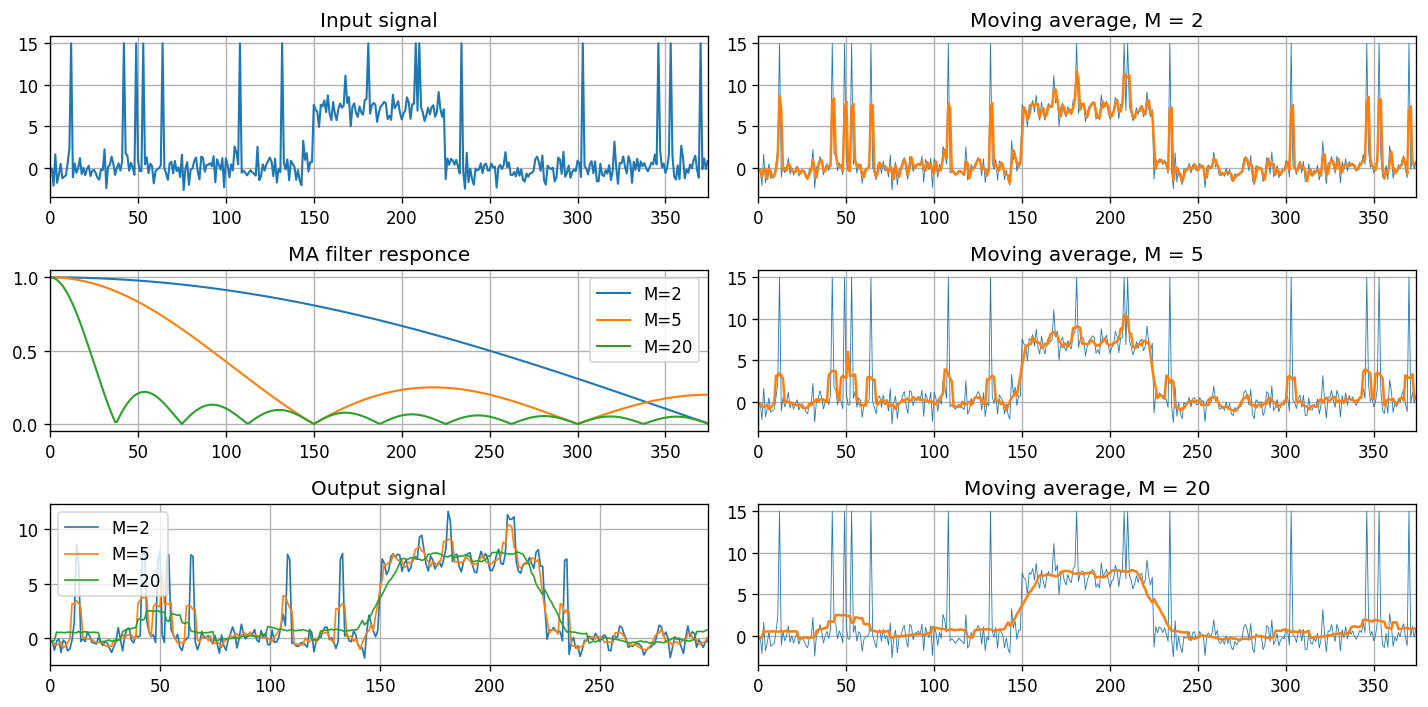

In [11]:
N = 300             # Number of samples
M = (2, 5, 20)      # Moving average step

LM = len(M)         # Size of M

# Input signal w/ noise:
sig = np.concatenate(
    (
        np.zeros(int(N/2)),
        np.ones(int(N/4)) * 7,
        np.zeros(int(N/2)))
)

lns = sig.size  # Size of signal

# Add some noise and peaks
np.random.seed(2)
sig += np.random.randn(lns)             # Add Gaussian noise
rnd = np.random.randint(0, lns, 15)     # Add random numbers for index
sig[rnd] = 15                           # Add peaks

# Calculate Moving Average filter:

filt = MafFilter(sig)
res = np.zeros((lns, LM))
for i in range(LM):
    res[:, i] = filt.maf_conv(m=M[i])

# Calculate Frequency responce:
hfq = np.zeros((lns, LM))
for j in range(LM):
    for i in range(lns):
        if i == 0:
            hfq[i, j] = 1
        else:
            hfq[i, j] = np.abs(np.sin(np.pi * M[j] * i / 2 / lns) / M[j] /
                               np.sin(np.pi * i / 2 / lns))

# Calculate spectrum of input signal:
fft_sig = np.abs(fft(sig))
fft_sig /= np.max(fft_sig)

# Calculate spectrum of output signal:
fft_out = np.zeros((lns, LM))
for i in range(LM):
    fft_out[:, i] = np.abs(fft(res[:, i]))
    fft_out[:, i] /= np.max(fft_out[:, i])

# Plot results:
plt.figure(figsize=(12, 6), dpi=120)
plt.subplot(3, 2, 1)
plt.plot(sig, linewidth=1.25)
plt.title('Input signal')
plt.grid()
plt.xlim([0, lns-1])

plt.subplot(3, 2, 3)
for i in range(LM):
    plt.plot(hfq[:, i], linewidth=1.25, label="M=%d" % M[i])
plt.title('MA filter responce')
plt.grid()
plt.legend(loc=1)
plt.xlim([0, lns-1])

plt.subplot(3, 2, 5)
for i in range(LM):
    plt.plot(res[:, i], linewidth=1.0, label="M=%d" % M[i])
plt.title('Output signal')
plt.grid()
plt.legend(loc=2)
plt.xlim([0, N-1])

for i in range(LM):
    plt.subplot(3, 2, 2*i+2)
    plt.plot(sig, '-', linewidth=0.5)
    plt.plot(res[:, i], linewidth=1.5)
    plt.title('Moving average, M = %d' % M[i])
    plt.grid()
    plt.xlim([0, lns-1])

plt.tight_layout()